In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial.distance import cdist
from scipy import stats
import tifffile

import sys; sys.path.append("../../")
import pykappa

# Set paths
data_dir = Path("/home/hadim/.data/Postdoc/Kappa/spiral_curve")

if data_dir.name.endswith("_SDM"):
  figure_dir = Path("Figures_SDM")
else:
  figure_dir = Path("Figures")
figure_dir.mkdir(exist_ok=True)

# Generated during dataset build
theoretical_curvatures_path = data_dir / "Original_Curve.csv"

figure_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('Figures')

---
## Single Curve Analysis

Plot curvature values and residuals for on single initialization curve in one image.

In [2]:
# Here we define the examples shown in the last figures of the paper.
# This is dependent on the dataset you are working with.

pixel_size = 0.16
dataset_types = ['variable_snr', 'variable_pixel_size', 'variable_initial_position', 'variable_psf_size']
feature_types = [int, float, float, float]

examples = {}

examples['variable_snr'] = {}
examples['variable_snr']['curve_id'] = 10
examples['variable_snr']['image_id'] = [12, 25]

examples['variable_pixel_size'] = {}
examples['variable_pixel_size']['curve_id'] = 5
examples['variable_pixel_size']['image_id'] = [5, 15]

examples['variable_initial_position'] = {}
examples['variable_initial_position']['curve_id'] = 5
examples['variable_initial_position']['image_id'] = [1, 8]

examples['variable_psf_size'] = {}
examples['variable_psf_size']['curve_id'] = 9
examples['variable_psf_size']['image_id'] = [0, 2]

In [3]:
dataset_type = 'variable_psf_size'
image_position = 1  # 0 or 1

image_id = examples[dataset_type]['image_id'][image_position]
curve_id = examples[dataset_type]['curve_id']

feature_type = feature_types[dataset_types.index(dataset_type)]

figure_output_dir = figure_dir / dataset_type
figure_output_dir.mkdir(exist_ok=True)

path_dir = data_dir / dataset_type
fname = sorted(list(path_dir.glob("*.tif")))[image_id]

feature_value = feature_type(fname.stem.split('_')[-2])

print(fname)
print(dataset_type, feature_value)

# Load image
im = tifffile.imread(str(fname))

# Load curvatures
curvatures = pd.read_csv(fname.with_suffix('.csv'))

/home/hadim/.data/Postdoc/Kappa/spiral_curve/variable_psf_size/psf_size_0.20_um.tif
variable_psf_size 0.2


In [15]:
# Load data for the selected image.
curvatures = pd.read_csv(fname.with_suffix('.csv'))
curvatures = curvatures[curvatures['Curve Name'] == f'CURVE {curve_id}']

x = curvatures["X-Coordinate (um)"].values
y = curvatures["Y-Coordinate (um)"].values
kappa = curvatures["Point Curvature (um-1)"].values

# Load theoretical data
theorical_curvatures = pd.read_csv(theoretical_curvatures_path)
xt = theorical_curvatures["y (um)"].values
yt = theorical_curvatures["x (um)"].values
kappat = theorical_curvatures["curvature (1/um)"].values
t = theorical_curvatures["tangential_angle"].values

# Convert positions as arrays
pos = np.array([x, y])
post = np.array([xt, yt])

# Try to 'align' both dataset
# by keeping in data, only points
# that are close to the theoretical curve.
distances = cdist(pos.T, post.T)
min_idx = distances.argmin(axis=0)

new_x = x[min_idx]
new_y = y[min_idx]
new_kappa = kappa[min_idx]

absolute_error = np.abs(new_kappa - kappat).mean()
pearson_coef, pvalue = stats.pearsonr(new_kappa, kappat)

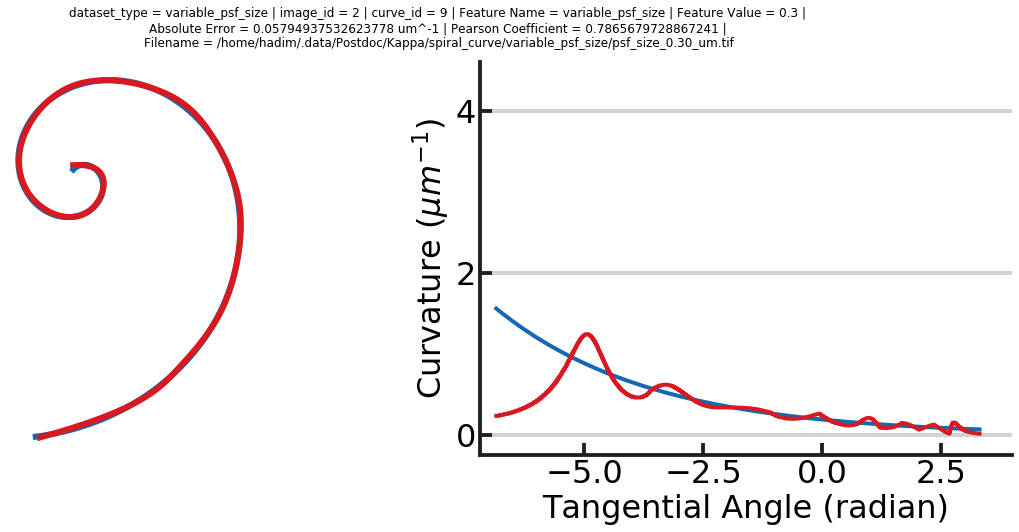

In [16]:
base_size = 16
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(base_size, base_size/2.2), constrained_layout=True)

ax1.plot(xt / pixel_size, yt / pixel_size, color='#1368b3ff', lw=6, alpha=1)
ax1.plot(new_x / pixel_size, new_y / pixel_size, color='#d81920ff', lw=6, alpha=1)
ax1.set_aspect('equal')
ax1.set_axis_off()

ax2.plot(t, kappat, color='#1368b3ff', lw=4, alpha=1)
ax2.plot(t, new_kappa, color='#d81920ff', lw=4, alpha=1)
ax2.set_xlabel("Tangential Angle (radian)")
ax2.set_ylabel("Curvature ($μm^{-1}$)")

ax2.set_xticks(np.arange(-7.5, 4, 2.5))
ax2.set_yticks(np.arange(0, 4.3, 2))

ax2.set_xlim(-7.2, 4)
ax2.set_ylim(-0.25, 4.6)

# Save metadata together with the image
metadata = ''
metadata += f'dataset_type = {dataset_type} | '
metadata += f'image_id = {image_id} | '
metadata += f'curve_id = {curve_id} | '
metadata += f'Feature Name = {dataset_type} | '
metadata += f'Feature Value = {feature_value} | '
metadata += '\n'
metadata += f'Absolute Error = {absolute_error} um^-1 | '
metadata += f'Pearson Coefficient = {pearson_coef} | '
metadata += '\n'
metadata += f'Filename = {fname}'
fig.suptitle(metadata)

kwargs = dict(font="DejaVu Sans", font_size_ratio=1, axes_color="#231f20ff", x_axis_grid=False)
pykappa.mpl.set_ax_style(ax1, y_axis_grid=False, **kwargs)
pykappa.mpl.set_ax_style(ax2, y_axis_grid=True, **kwargs)

fig_name = f"single-feature-{dataset_type}-{feature_value}-curve_id-{curve_id}.svg"
figure_path = figure_output_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

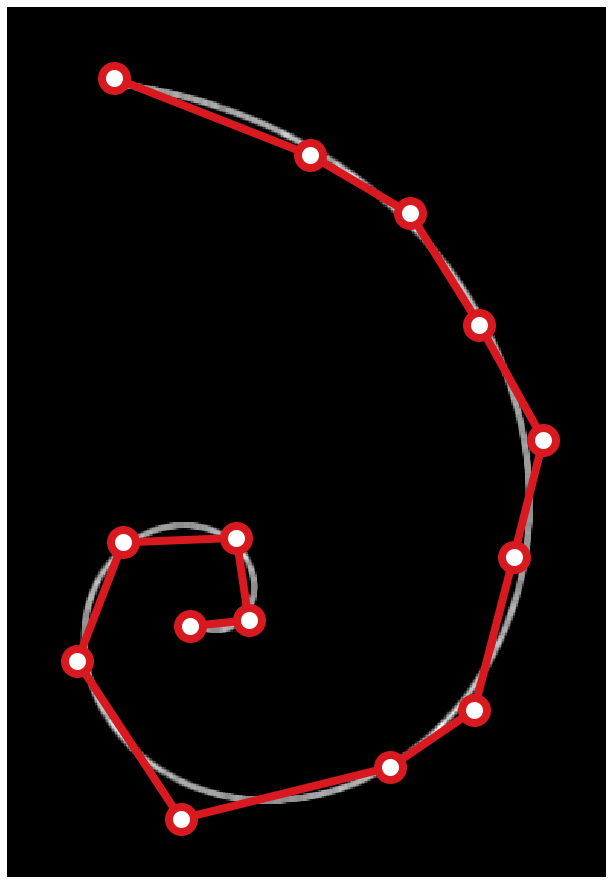

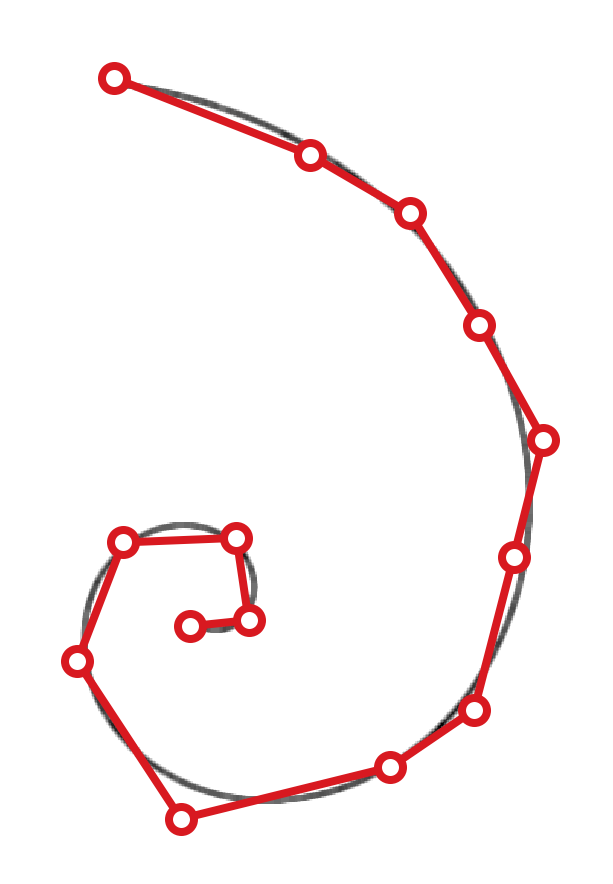

In [17]:
# Plot the image and its curve

image = tifffile.imread(str(fname))
curves = pykappa.io.parse_kappa(fname.with_suffix('.kapp'))
curve = curves[curve_id - 1]
pos = curve['curve_pos']

# Save raw image
tifffile.imsave(str(figure_path.with_suffix(".IMAGE.tif")), image)
tifffile.imsave(str(figure_path.with_suffix(".IMAGE_INVERTED.tif")), np.invert(image))

base_size = 16
fig, ax = plt.subplots(figsize=(base_size, base_size))

ax.imshow(image, aspect='equal', interpolation='none', cmap='gray')
ax.plot(pos[:, 0], pos[:, 1], color="#d81920ff", lw=8, marker='o', ms=25,
        markeredgecolor='#d81920ff',
        markerfacecolor='#ffffff',
        markeredgewidth=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

fig.savefig(figure_path.with_suffix(".CONTROL_POINTS.png"), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

base_size = 16
fig, ax = plt.subplots(figsize=(base_size, base_size))

ax.imshow(np.invert(image), aspect='equal', interpolation='none', cmap='gray')
ax.plot(pos[:, 0], pos[:, 1], color="#d81920ff", lw=8, marker='o', ms=25,
        markeredgecolor='#d81920ff',
        markerfacecolor='#ffffff',
        markeredgewidth=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
fig.savefig(figure_path.with_suffix(".IMAGE_INVERTED.CONTROL_POINTS.png"), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

## Batch single examples analysis

In [ ]:
for dataset_type, params in examples.items():
  print(dataset_type)
  for image_id in params['image_id']:
    curve_id = examples[dataset_type]['curve_id']

    feature_type = feature_types[dataset_types.index(dataset_type)]

    figure_output_dir = figure_dir / dataset_type
    figure_output_dir.mkdir(exist_ok=True)

    path_dir = data_dir / dataset_type
    fname = sorted(list(path_dir.glob("*.tif")))[image_id]

    feature_value = feature_type(fname.stem.split('_')[-2])

    print(fname)
    print(dataset_type, feature_value)

    # Load image
    im = tifffile.imread(str(fname))

    # Load curvatures
    curvatures = pd.read_csv(fname.with_suffix('.csv'))

    # Load data for the selected image.
    curvatures = pd.read_csv(fname.with_suffix('.csv'))
    curvatures = curvatures[curvatures['Curve Name'] == f'CURVE {curve_id}']

    x = curvatures["X-Coordinate (um)"].values
    y = curvatures["Y-Coordinate (um)"].values
    kappa = curvatures["Point Curvature (um-1)"].values

    # Load theoretical data
    theorical_curvatures = pd.read_csv(theoretical_curvatures_path)
    xt = theorical_curvatures["y (um)"].values
    yt = theorical_curvatures["x (um)"].values
    kappat = theorical_curvatures["curvature (1/um)"].values
    t = theorical_curvatures["tangential_angle"].values

    # Convert positions as arrays
    pos = np.array([x, y])
    post = np.array([xt, yt])

    # Try to 'align' both dataset
    # by keeping in data, only points
    # that are close to the theoretical curve.
    distances = cdist(pos.T, post.T)
    min_idx = distances.argmin(axis=0)

    new_x = x[min_idx]
    new_y = y[min_idx]
    new_kappa = kappa[min_idx]

    absolute_error = np.abs(new_kappa - kappat).mean()
    pearson_coef, pvalue = stats.pearsonr(new_kappa, kappat)

    base_size = 16
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(base_size, base_size/2.2), constrained_layout=True)

    ax1.plot(xt / pixel_size, yt / pixel_size, color='#1368b3ff', lw=6, alpha=1)
    ax1.plot(new_x / pixel_size, new_y / pixel_size, color='#d81920ff', lw=6, alpha=1)
    ax1.set_aspect('equal')
    ax1.set_axis_off()

    ax2.plot(t, kappat, color='#1368b3ff', lw=4, alpha=1)
    ax2.plot(t, new_kappa, color='#d81920ff', lw=4, alpha=1)
    ax2.set_xlabel("Tangential Angle (radian)")
    ax2.set_ylabel("Curvature ($μm^{-1}$)")

    ax2.set_xticks(np.arange(-7.5, 4, 2.5))
    ax2.set_yticks(np.arange(0, 4.3, 2))

    ax2.set_xlim(-7.2, 4)
    ax2.set_ylim(-0.25, 4.6)

    # Save metadata together with the image
    metadata = ''
    metadata += f'dataset_type = {dataset_type} | '
    metadata += f'image_id = {image_id} | '
    metadata += f'curve_id = {curve_id} | '
    metadata += f'Feature Name = {dataset_type} | '
    metadata += f'Feature Value = {feature_value} | '
    metadata += '\n'
    metadata += f'Absolute Error = {absolute_error} um^-1 | '
    metadata += f'Pearson Coefficient = {pearson_coef} | '
    metadata += '\n'
    metadata += f'Filename = {fname}'
    fig.suptitle(metadata)

    kwargs = dict(font="DejaVu Sans", font_size_ratio=1, axes_color="#231f20ff", x_axis_grid=False)
    pykappa.mpl.set_ax_style(ax1, y_axis_grid=False, **kwargs)
    pykappa.mpl.set_ax_style(ax2, y_axis_grid=True, **kwargs)

    fig_name = f"single-feature-{dataset_type}-{feature_value}-curve_id-{curve_id}.svg"
    figure_path = figure_output_dir / fig_name
    fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

    # Plot the image and its curve

    image = tifffile.imread(str(fname))
    curves = pykappa.io.parse_kappa(fname.with_suffix('.kapp'))
    curve = curves[curve_id - 1]
    pos = curve['curve_pos']

    # Save raw image
    tifffile.imsave(str(figure_path.with_suffix(".IMAGE.tif")), image)
    tifffile.imsave(str(figure_path.with_suffix(".IMAGE_INVERTED.tif")), np.invert(image))

    base_size = 16
    fig, ax = plt.subplots(figsize=(base_size, base_size))

    ax.imshow(image, aspect='equal', interpolation='none', cmap='gray')
    ax.plot(pos[:, 0], pos[:, 1], color="#d81920ff", lw=8, marker='o', ms=25,
            markeredgecolor='#d81920ff',
            markerfacecolor='#ffffff',
            markeredgewidth=8)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

    fig.savefig(figure_path.with_suffix(".CONTROL_POINTS.png"), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)
    
    base_size = 16
    fig, ax = plt.subplots(figsize=(base_size, base_size))

    ax.imshow(np.invert(image), aspect='equal', interpolation='none', cmap='gray')
    ax.plot(pos[:, 0], pos[:, 1], color="#d81920ff", lw=8, marker='o', ms=25,
            markeredgecolor='#d81920ff',
            markerfacecolor='#ffffff',
            markeredgewidth=8)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    fig.savefig(figure_path.with_suffix(".IMAGE_INVERTED.CONTROL_POINTS.png"), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

---
## Analyze the "Variable SNR" dataset

In [4]:
feature_name = 'variable_snr'
feature_type = float

path_dir = data_dir / feature_name
fnames = list(path_dir.glob("*.tif"))

# Load theoretical data
theorical_curvatures = pd.read_csv(theoretical_curvatures_path)
xt = theorical_curvatures["y (um)"].values
yt = theorical_curvatures["x (um)"].values
kappat = theorical_curvatures["curvature (1/um)"].values
t = theorical_curvatures["tangential_angle"].values

data = []
for fname in tqdm(fnames, total=len(fnames)):
    
    curvatures = pd.read_csv(fname.with_suffix('.csv'))
    feature_value = feature_type(fname.stem.split('_')[-2])
    
    for curve_name, df in curvatures.groupby('Curve Name'):
        
        x = df["X-Coordinate (um)"].values
        y = df["Y-Coordinate (um)"].values
        kappa = df["Point Curvature (um-1)"].values
        
        # Convert positions as arrays
        pos = np.array([x, y])
        post = np.array([xt, yt])

        # Try to 'align' both dataset
        # by keeping in data, only points
        # that are close to the theoretical curve.
        distances = cdist(pos.T, post.T)
        min_idx = distances.argmin(axis=0)

        new_x = x[min_idx]
        new_y = y[min_idx]
        new_kappa = kappa[min_idx]
        
        datum = {}
        datum['feature'] = feature_value
        datum['fname'] = fname.relative_to(data_dir)
        datum['curve_name'] = curve_name
        datum['kappa'] = new_kappa.mean()
        datum['kappa_error'] = np.abs(new_kappa - kappat).mean()
        datum['pearson_coef'], _ = stats.pearsonr(new_kappa, kappat)
        
        data.append(datum)
        
data = pd.DataFrame(data)

In [8]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['kappa'] - kappat.mean()).abs()
grouped = grouped.reset_index()
grouped

,feature,curve_name,kappa,kappa_error,pearson_coef,average_error
0,0.0,CURVE 1,0.181455,0.130683,0.197743,0.044621
1,0.0,CURVE 10,0.147662,0.105276,0.255408,0.078413
2,0.0,CURVE 2,0.162371,0.127680,0.174783,0.063704
3,0.0,CURVE 3,0.184903,0.133903,0.452147,0.041173
4,0.0,CURVE 4,0.238011,0.247424,0.167014,0.011935
...,...,...,...,...,...,...
255,25.0,CURVE 5,0.188646,0.072800,0.599556,0.037430
256,25.0,CURVE 6,0.209447,0.071809,0.733646,0.016628
257,25.0,CURVE 7,0.211678,0.066655,0.756449,0.014398
258,25.0,CURVE 8,0.224386,0.077568,0.757685,0.001690


In [10]:
df = grouped.groupby('feature').mean()
df.loc[20:25].mean()

kappa            0.210868
kappa_error      0.073805
pearson_coef     0.748981
average_error    0.018449
dtype: float64

In [14]:
kappat.mean()

0.2260757407181085

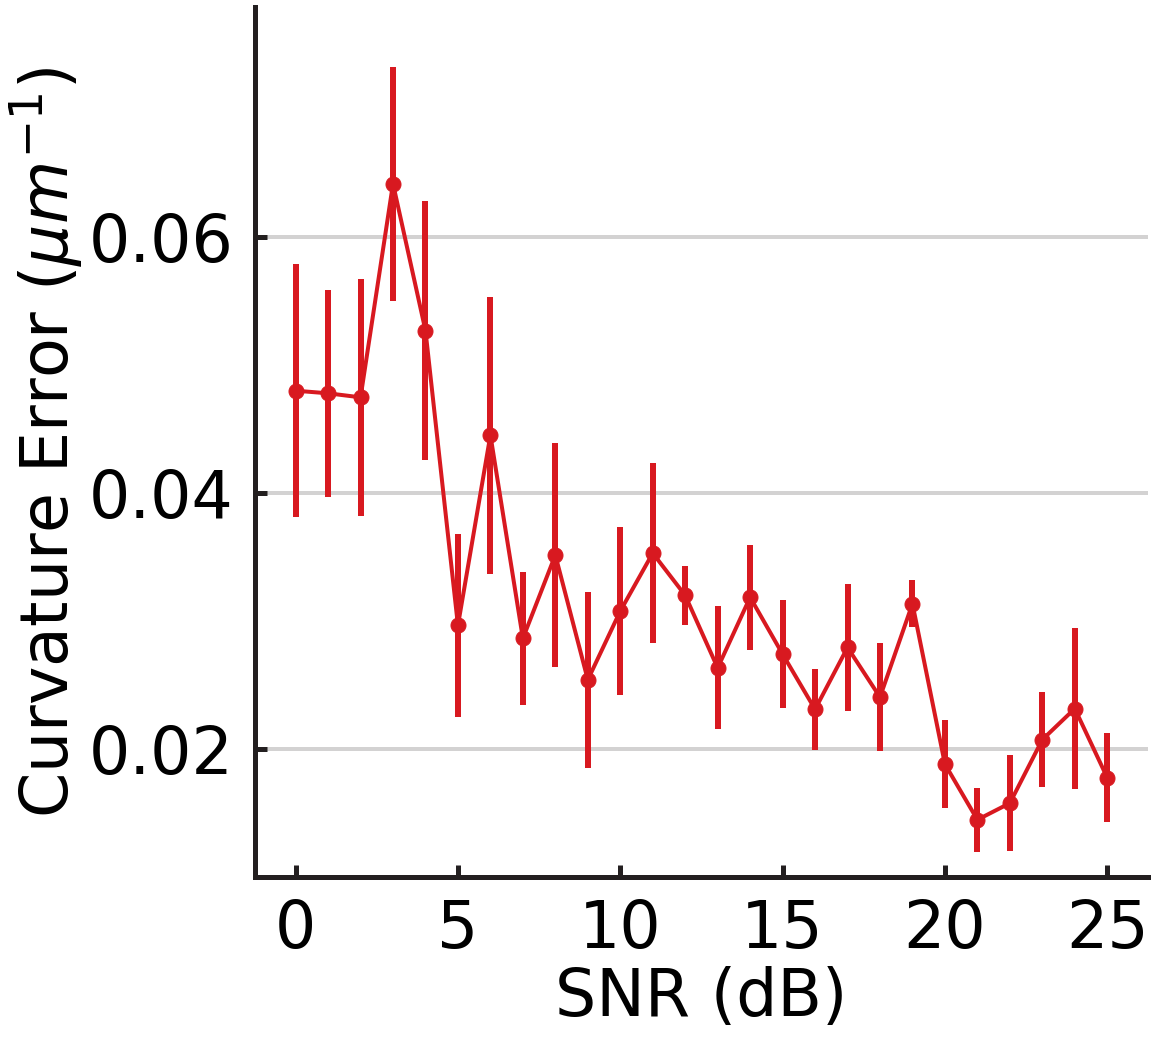

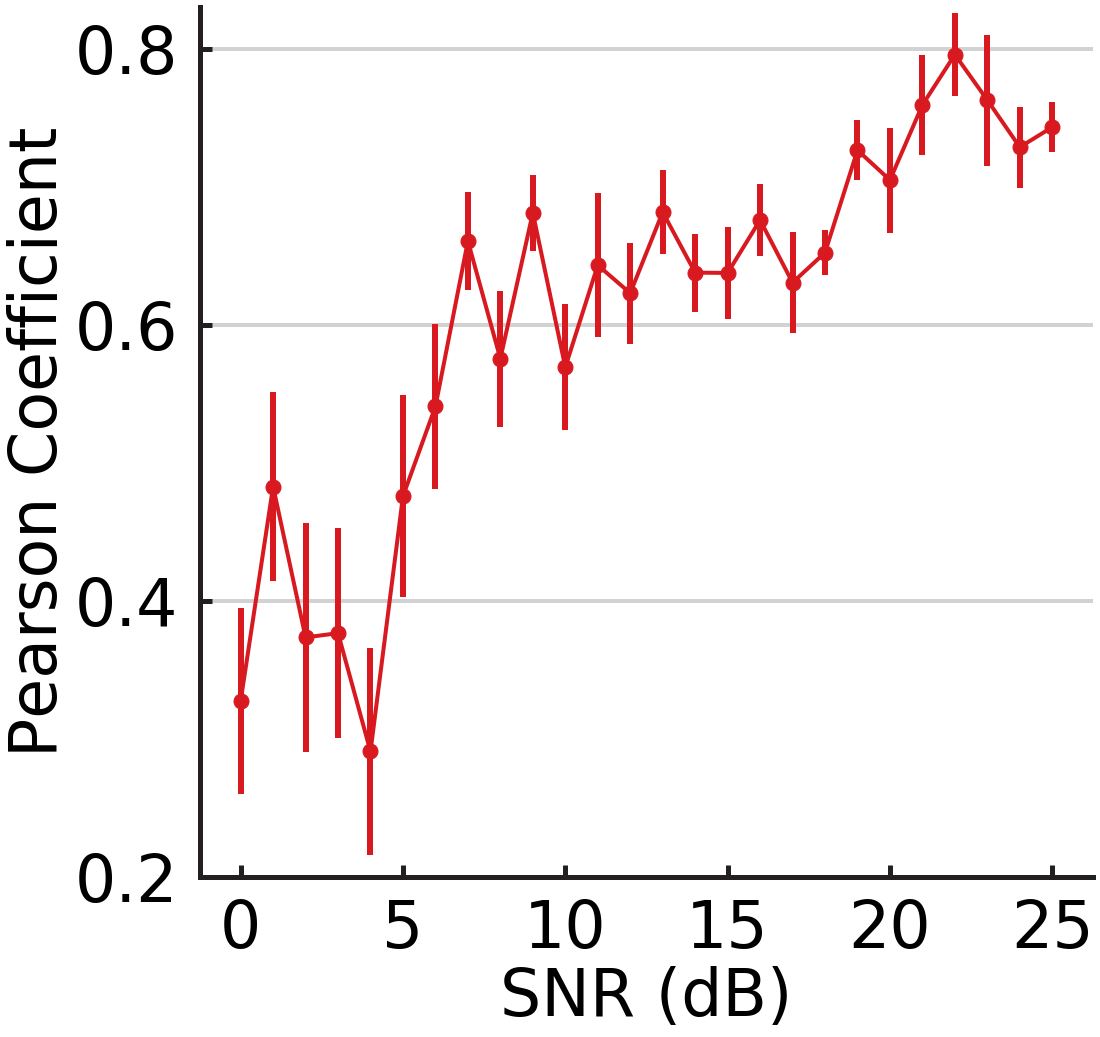

In [3]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['kappa'] - kappat.mean()).abs()
grouped = grouped.reset_index()

base_size = 16
x_label = "SNR (dB)"
x_ticks = np.arange(0, 26, 5)
x_lim = None
color = "#d81920"
labels_spacing = 0.02

# Plot absolute error
metric_label = 'average_error'
metric_name = "Curvature Error ($μm^{-1}$)"
y_ticks = np.arange(0, 0.21, 0.02)
y_lim = (0.01, 0.078)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color,
                             base_size=base_size)
fig_name = f"{feature_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Plot pearson coeff
metric_label = 'pearson_coef'
metric_name = "Pearson Coefficient"
y_ticks = np.arange(0.2, 0.8, 0.2)
y_lim = (0.2, 0.83)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{feature_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

---
## Analyze the "Variable Pixel Size" dataset

In [4]:
feature_name = 'variable_pixel_size'
feature_type = float

path_dir = data_dir / feature_name
fnames = list(path_dir.glob("*.tif"))

# Load theoretical data
theorical_curvatures = pd.read_csv(theoretical_curvatures_path)
xt = theorical_curvatures["y (um)"].values
yt = theorical_curvatures["x (um)"].values
kappat = theorical_curvatures["curvature (1/um)"].values
t = theorical_curvatures["tangential_angle"].values

data = []
for fname in tqdm(fnames, total=len(fnames)):
    
    curvatures = pd.read_csv(fname.with_suffix('.csv'))
    feature_value = feature_type(fname.stem.split('_')[-2])
    
    for curve_name, df in curvatures.groupby('Curve Name'):
        x = df["X-Coordinate (um)"].values
        y = df["Y-Coordinate (um)"].values
        kappa = df["Point Curvature (um-1)"].values
        
        # Convert positions as arrays
        pos = np.array([x, y])
        post = np.array([xt, yt])

        # Try to 'align' both dataset
        # by keeping in data, only points
        # that are close to the theoretical curve.
        distances = cdist(pos.T, post.T)
        min_idx = distances.argmin(axis=0)

        new_x = x[min_idx]
        new_y = y[min_idx]
        new_kappa = kappa[min_idx]
        
        datum = {}
        datum['feature'] = feature_value
        datum['fname'] = fname.relative_to(data_dir)
        datum['curve_name'] = curve_name
        datum['kappa'] = new_kappa.mean()
        datum['kappa_error'] = np.abs(new_kappa - kappat).mean()
        datum['pearson_coef'], _ = stats.pearsonr(new_kappa, kappat)
        
        data.append(datum)
        
data = pd.DataFrame(data)

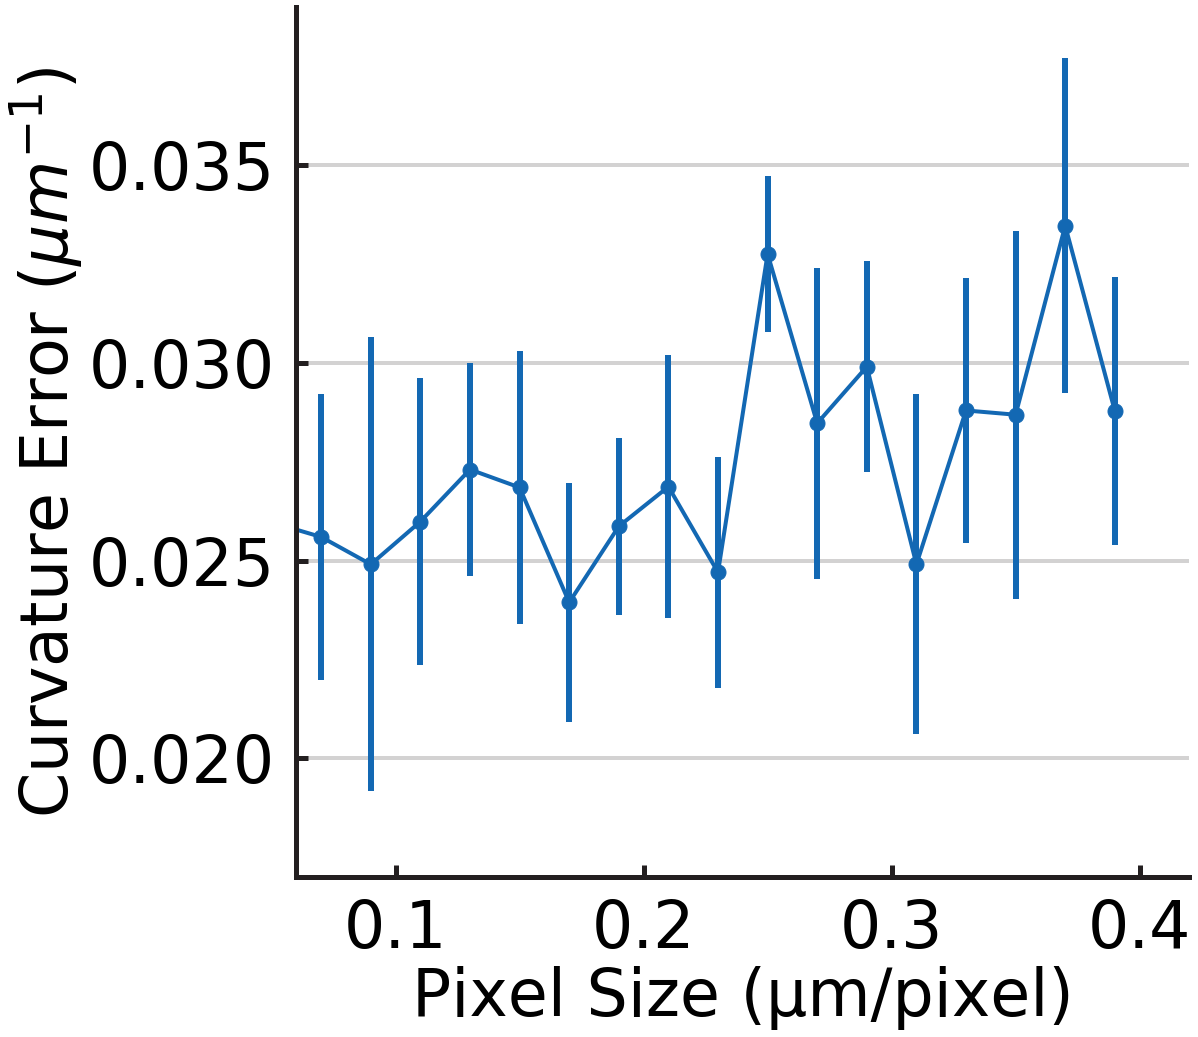

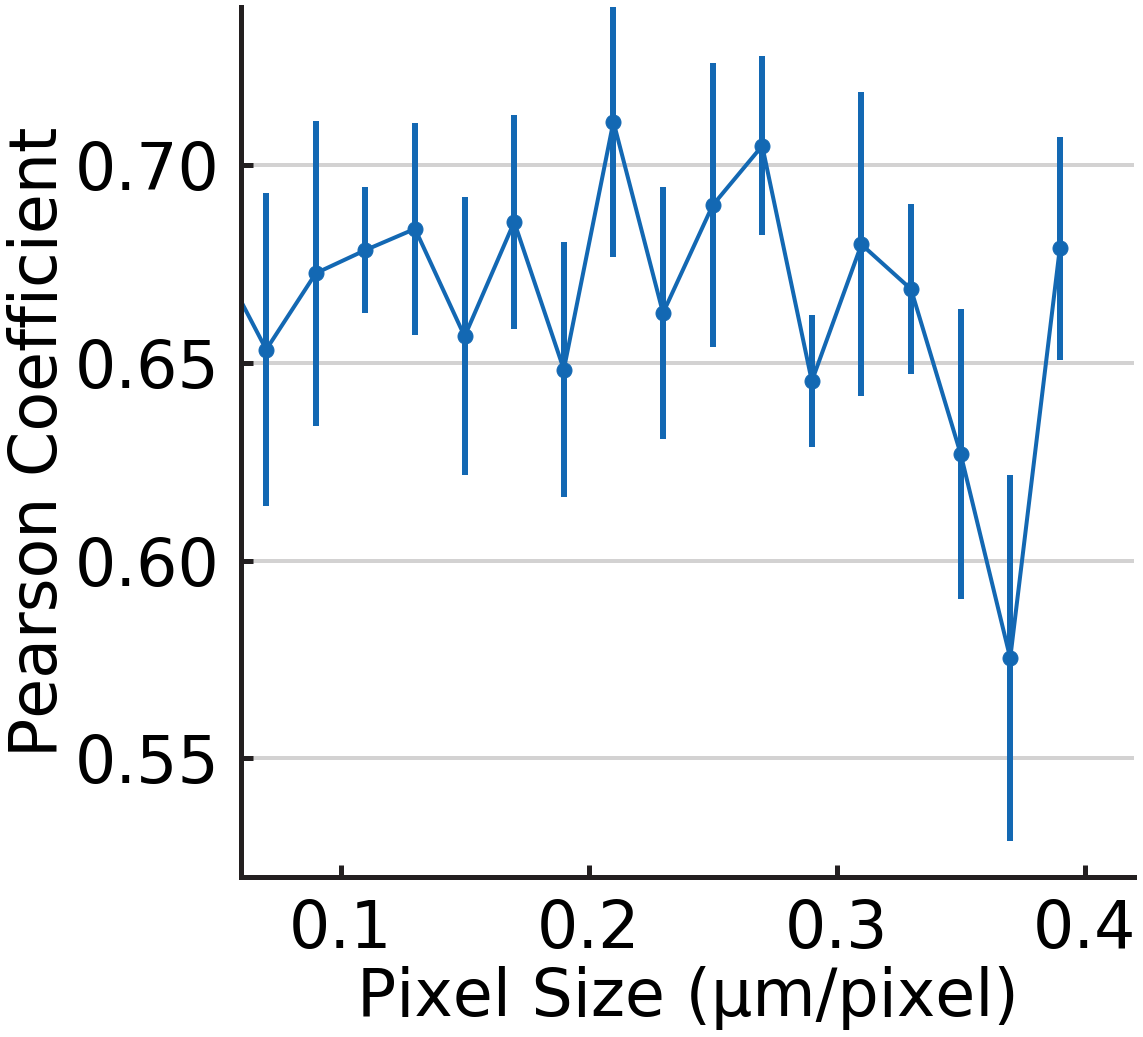

In [5]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['kappa'] - kappat.mean()).abs()
grouped = grouped.reset_index()

base_size = 16
x_label = "Pixel Size (μm/pixel)"
x_ticks = np.arange(0, 0.42, 0.1)
x_lim = (0.06, 0.42)
color = "#1368b3"
labels_spacing = 0.02

# Plot absolute error
metric_label = 'average_error'
metric_name = "Curvature Error ($μm^{-1}$)"
y_ticks = np.arange(0, 0.30, 0.005)
y_lim = (0.017, 0.039)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color,
                             base_size=base_size)
fig_name = f"{feature_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Plot pearson coeff
metric_label = 'pearson_coef'
metric_name = "Pearson Coefficient"
y_ticks = np.arange(0.2, 0.8, 0.05)
y_lim = (0.52, 0.74)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{feature_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

---
## Analyze the "Variable Initial Curve" dataset

In [85]:
feature_name = 'variable_initial_position'
feature_type = float

path_dir = data_dir / feature_name
fnames = list(path_dir.glob("*.tif"))

# Load theoretical data
theorical_curvatures = pd.read_csv(theoretical_curvatures_path)
xt = theorical_curvatures["y (um)"].values
yt = theorical_curvatures["x (um)"].values
kappat = theorical_curvatures["curvature (1/um)"].values
t = theorical_curvatures["tangential_angle"].values

data = []
for fname in tqdm(fnames, total=len(fnames)):
    
    curvatures = pd.read_csv(fname.with_suffix('.csv'))
    feature_value = feature_type(fname.stem.split('_')[-2])
    
    for curve_name, df in curvatures.groupby('Curve Name'):
        x = df["X-Coordinate (um)"].values
        y = df["Y-Coordinate (um)"].values
        kappa = df["Point Curvature (um-1)"].values
        
        # Convert positions as arrays
        pos = np.array([x, y])
        post = np.array([xt, yt])

        # Try to 'align' both dataset
        # by keeping in data, only points
        # that are close to the theoretical curve.
        distances = cdist(pos.T, post.T)
        min_idx = distances.argmin(axis=0)

        new_x = x[min_idx]
        new_y = y[min_idx]
        new_kappa = kappa[min_idx]
        
        datum = {}
        datum['feature'] = feature_value
        datum['fname'] = fname.relative_to(data_dir)
        datum['curve_name'] = curve_name
        datum['kappa'] = new_kappa.mean()
        datum['kappa_error'] = np.abs(new_kappa - kappat).mean()
        datum['pearson_coef'], _ = stats.pearsonr(new_kappa, kappat)
        
        data.append(datum)
        
data = pd.DataFrame(data)

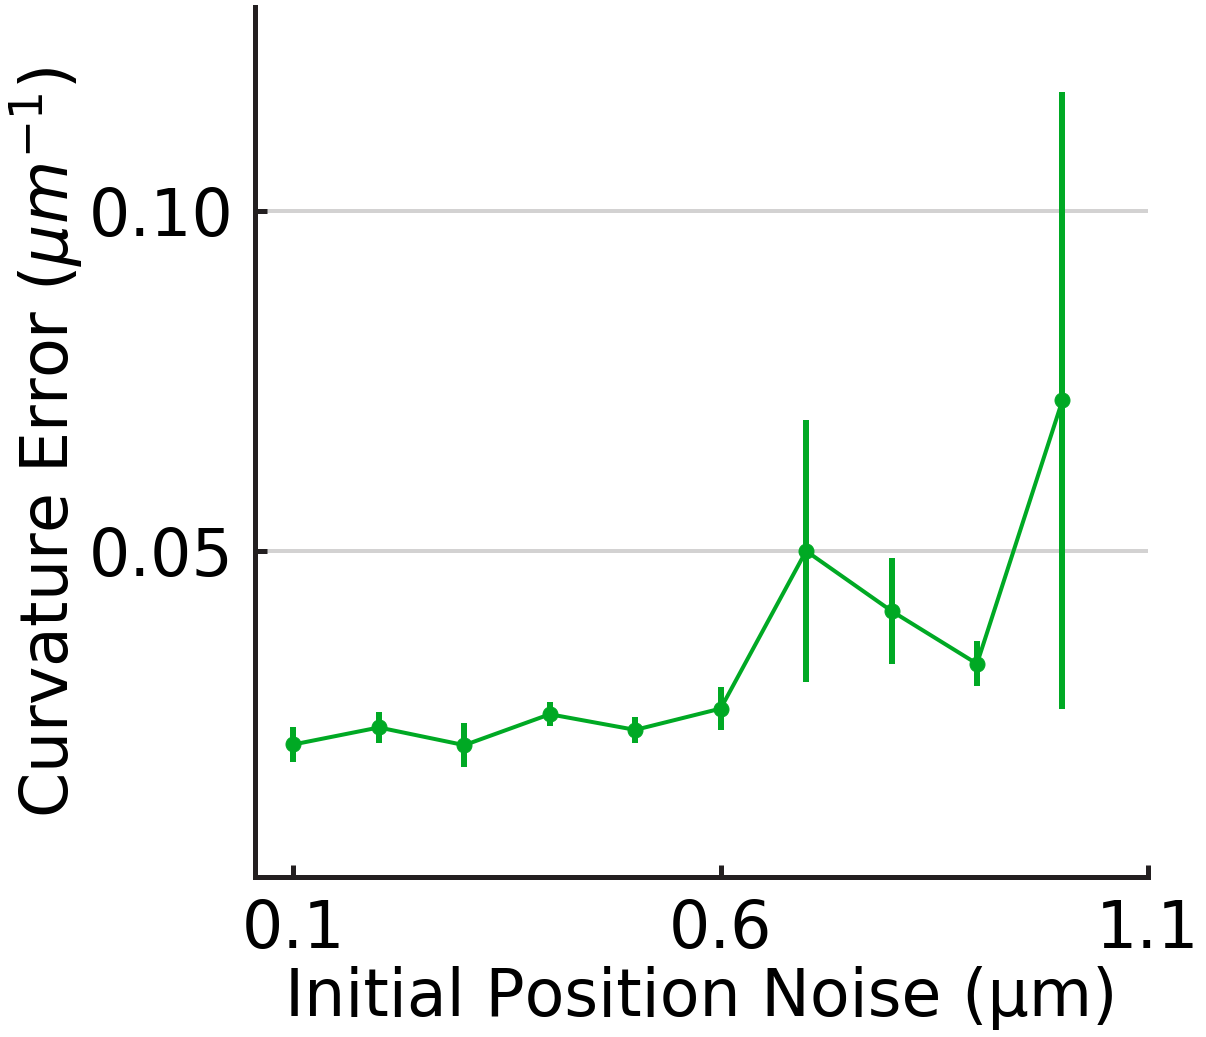

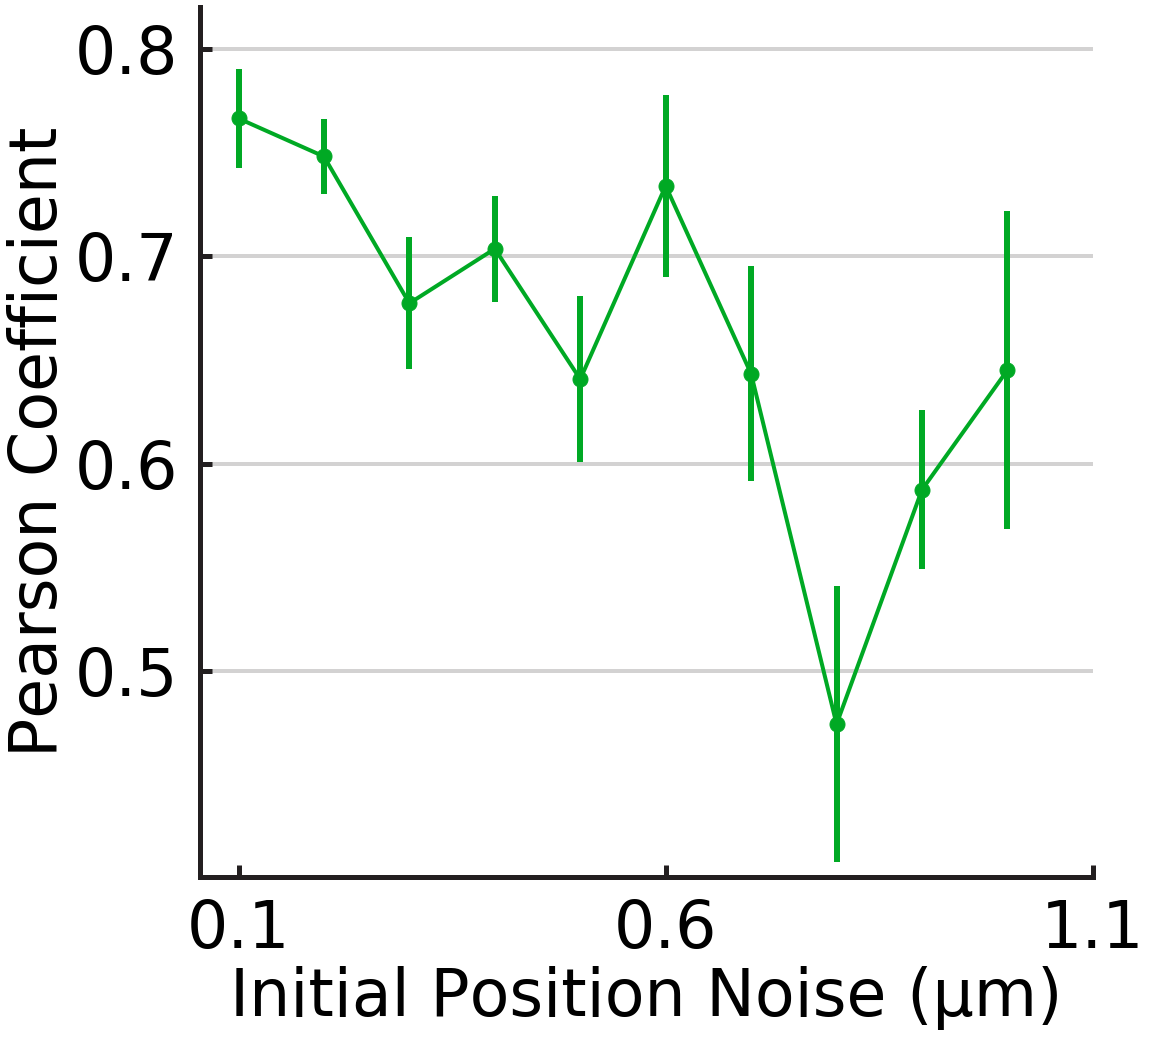

In [86]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['kappa'] - kappat.mean()).abs()
grouped = grouped.reset_index()

# Only keep initial_position <= 1.0
filtered_grouped = grouped[grouped.feature <= 1.0]

base_size = 16
x_label = "Initial Position Noise (μm)"
x_ticks = np.arange(0.1, 1.4, 0.5)
x_lim = None
color = "#00a924ff"
labels_spacing = 0.02

# Plot absolute error
metric_label = 'average_error'
metric_name = "Curvature Error ($μm^{-1}$)"
y_ticks = np.arange(0, 0.30, 0.05)
y_lim = (0.002, 0.13)
fig = pykappa.mpl.plot_error(filtered_grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color,
                             base_size=base_size)
fig_name = f"{feature_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Plot pearson coeff
metric_label = 'pearson_coef'
metric_name = "Pearson Coefficient"
y_ticks = np.arange(0.5, 0.8, 0.1)
y_lim = (0.401, 0.82)
fig = pykappa.mpl.plot_error(filtered_grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{feature_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

---
## Analyze the "Variable PSF Size" dataset

In [28]:
feature_name = 'variable_psf_size'
feature_type = float

path_dir = data_dir / feature_name
fnames = list(path_dir.glob("*.tif"))

# Load theoretical data
theorical_curvatures = pd.read_csv(theoretical_curvatures_path)
xt = theorical_curvatures["y (um)"].values
yt = theorical_curvatures["x (um)"].values
kappat = theorical_curvatures["curvature (1/um)"].values
t = theorical_curvatures["tangential_angle"].values

data = []
for fname in tqdm(fnames, total=len(fnames)):
    
    if fname.with_suffix('.csv').is_file():
      curvatures = pd.read_csv(fname.with_suffix('.csv'))
      feature_value = feature_type(fname.stem.split('_')[-2])

      for curve_name, df in curvatures.groupby('Curve Name'):
          x = df["X-Coordinate (um)"].values
          y = df["Y-Coordinate (um)"].values
          kappa = df["Point Curvature (um-1)"].values

          # Convert positions as arrays
          pos = np.array([x, y])
          post = np.array([xt, yt])

          # Try to 'align' both dataset
          # by keeping in data, only points
          # that are close to the theoretical curve.
          distances = cdist(pos.T, post.T)
          min_idx = distances.argmin(axis=0)

          new_x = x[min_idx]
          new_y = y[min_idx]
          new_kappa = kappa[min_idx]

          datum = {}
          datum['feature'] = feature_value
          datum['fname'] = fname.relative_to(data_dir)
          datum['curve_name'] = curve_name
          datum['kappa'] = new_kappa.mean()
          datum['kappa_error'] = np.abs(new_kappa - kappat).mean()
          datum['pearson_coef'], _ = stats.pearsonr(new_kappa, kappat)

          data.append(datum)
        
data = pd.DataFrame(data)

In [24]:
grouped.groupby('feature').mean()

,kappa,kappa_error,pearson_coef,average_error
feature,,,,
0.00,0.214156,0.046767,0.864819,0.011919
0.05,0.212571,0.044751,0.861200,0.013505
0.20,0.216496,0.044385,0.896642,0.010433
0.30,0.216013,0.049543,0.867199,0.013143
0.60,0.231359,0.054757,0.847568,0.021267
0.80,0.222714,0.052340,0.876261,0.016552
1.00,10.818336,10.651314,0.800450,10.602777


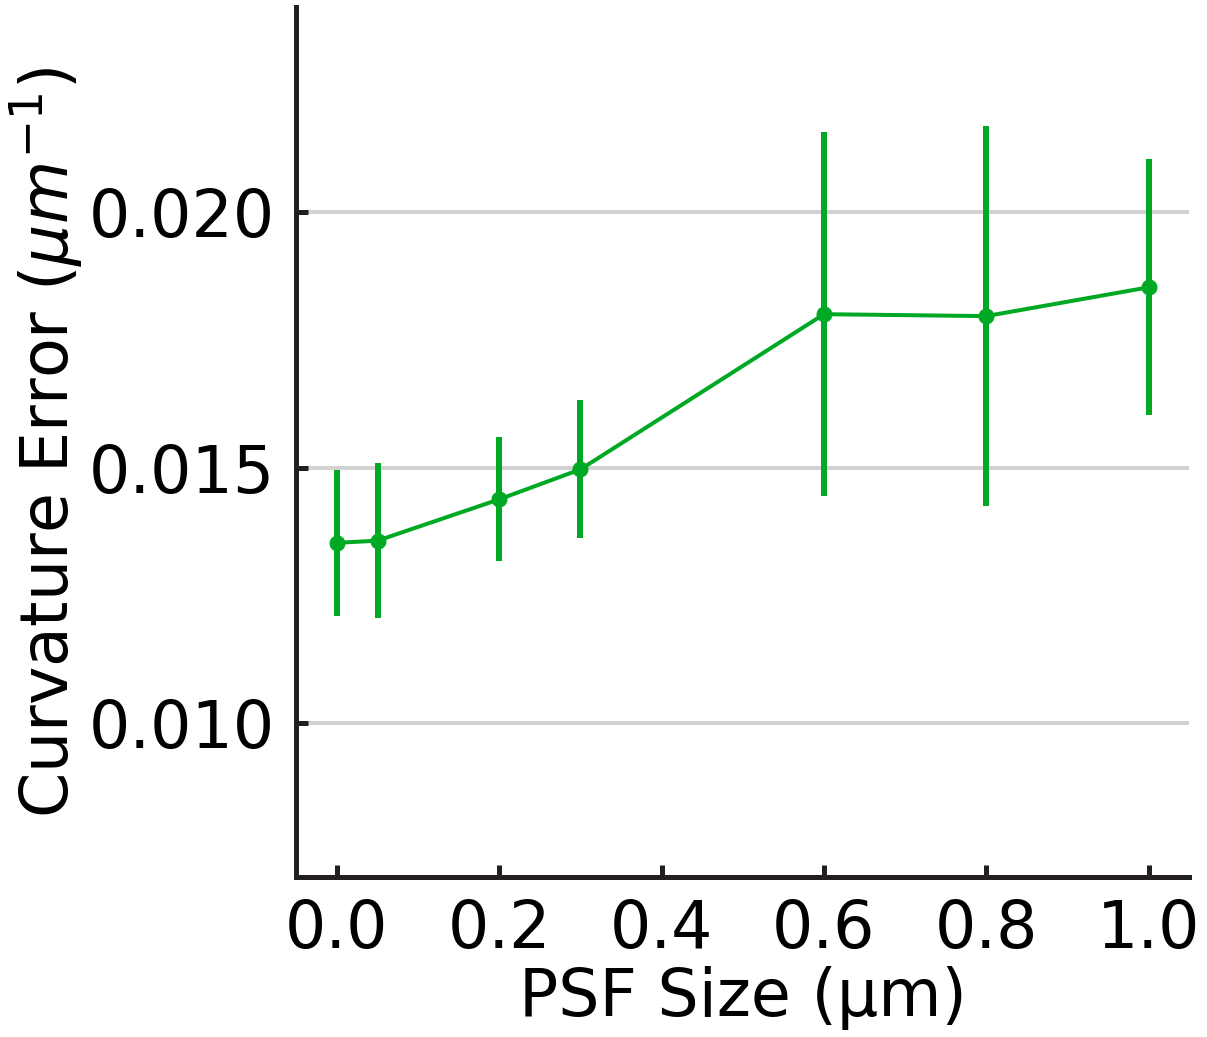

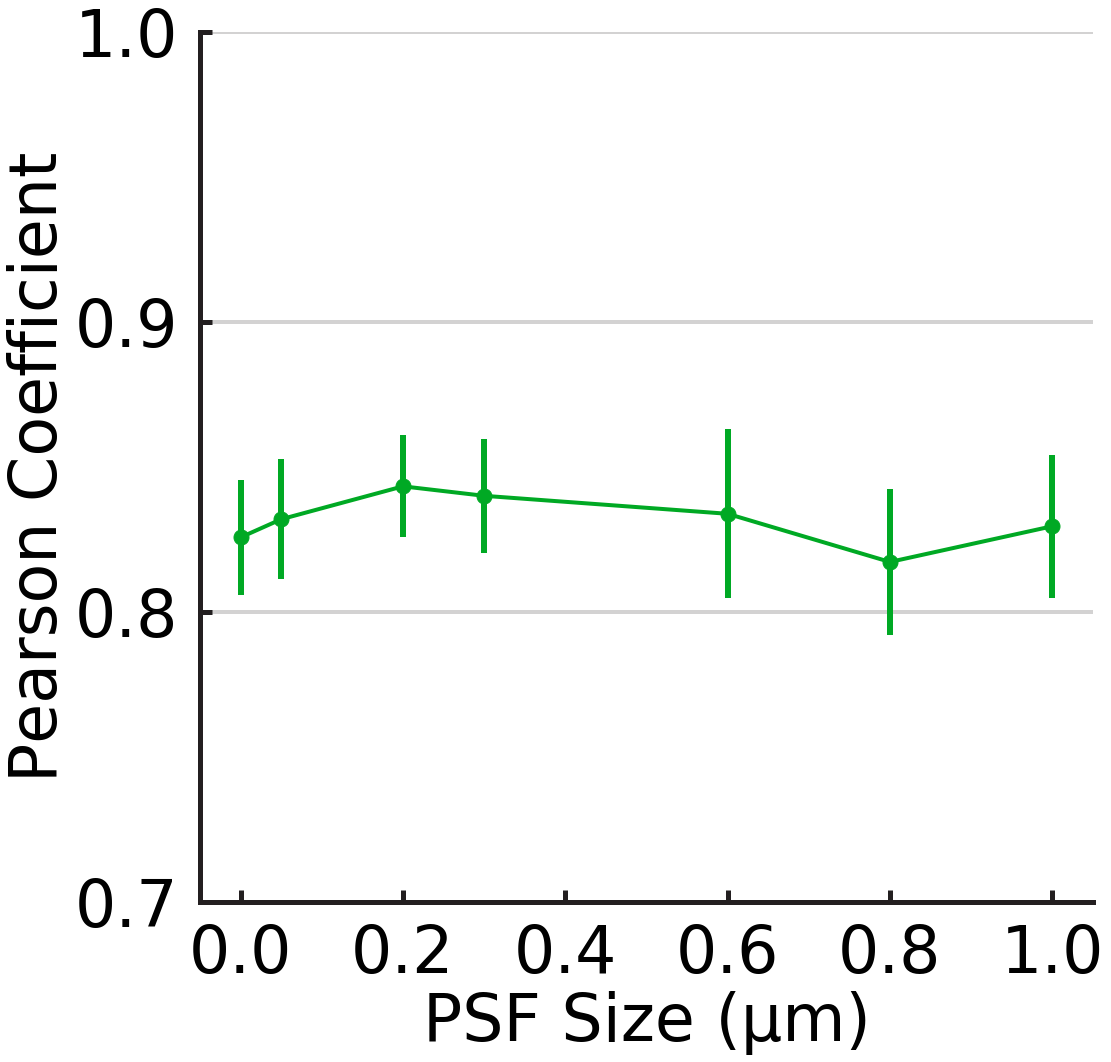

In [29]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['kappa'] - kappat.mean()).abs()
grouped = grouped.reset_index()

base_size = 16
x_label = "PSF Size (μm)"
x_ticks = np.arange(0, 1.1, 0.2)
x_lim = None
color = "#00a924ff"
labels_spacing = 0.02

#plt.ioff()

# Plot absolute error
metric_label = 'average_error'
metric_name = "Curvature Error ($μm^{-1}$)"
y_ticks = np.arange(0, 0.08, 0.005)
y_lim = (0.007, 0.024)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{feature_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Plot pearson coeff
metric_label = 'pearson_coef'
metric_name = "Pearson Coefficient"
y_ticks = np.arange(0.5, 1.1, 0.1)
y_lim = (0.7, 1.0)
fig = pykappa.mpl.plot_error(data, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{feature_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

#plt.ion()